## 1. Imports

In [9]:
import asimov_database as ad
import warnings
import gc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pytz
from datetime import datetime
import seaborn as sns
warnings.filterwarnings("ignore")

## 2. Data ingestion & basic manipulation

In [12]:
pr = ad.ParquetReader()

symbol1 = 'WDOZ19'
symbol2 = 'DOLZ19'
date = '2019-11-13'
columns = 10
overwrite = False

In [13]:
level_data = pr.get_parquet(symbol2, date, "order-book")

ArrowIOError: Failed to open local file '/bigdata/order-book/DOLZ19-inc_code-bid-2019-11-13.parquet', error: No such file or directory

In [3]:
# wdo_level_data = db.get_level_price_data(symbol1, date, columns, overwrite)
# dol_level_data = db.get_level_price_data(symbol2, date, columns, overwrite)



wdo_level_data.columns = ['wdo_{}'.format(i) for i in wdo_level_data.columns]
dol_level_data.columns = ['dol_{}'.format(i) for i in dol_level_data.columns]

full_data = pd.concat([wdo_level_data, dol_level_data])
full_data[['wdo_msg_seq_num', 'dol_msg_seq_num']] = full_data[['wdo_msg_seq_num', 'dol_msg_seq_num']].fillna(value=0)
full_data['msg_seq_num'] = full_data['wdo_msg_seq_num'] + full_data['dol_msg_seq_num']
full_data = full_data.sort_values('msg_seq_num', kind='mergesort')

In [5]:
cols = ['dol_ask_{}'.format(i) for i in range(10)] + ['dol_bid_{}'.format(i) for i in range(10)] + ['wdo_ask_{}'.format(i) for i in range(10)] + ['wdo_bid_{}'.format(i) for i in range(10)]
full_data[cols] = full_data[cols].ffill()

full_data = full_data[['wdo_ask_0', 'wdo_bid_0', 'dol_ask_0', 'dol_bid_0', 'dol_inc_code', 'wdo_inc_code', 'msg_seq_num', 'wdo_event', 'dol_event']]

NameError: name 'full_data' is not defined

In [5]:
wdo_events = db.get_parquet(symbol1, date, 'events', False)
dol_events = db.get_parquet(symbol2, date, 'events', False)
wdo_trades = db.get_parquet(symbol1, date, 'trades', False)
dol_trades = db.get_parquet(symbol2, date, 'trades', False)

wdo_events = wdo_events['incremental'].read().to_pandas()
dol_events = dol_events['incremental'].read().to_pandas()
wdo_trades = wdo_trades.read().to_pandas()
dol_trades = dol_trades.read().to_pandas()

events = pd.concat([wdo_events, dol_events]).sort_values(['i'])
events['trade_event'] = (events['msg_seq_num'].isin(wdo_trades['msg_seq_num'])) | (events['msg_seq_num'].isin(dol_trades['msg_seq_num']))

In [39]:
events[(events['event_type'] == 'DELETE') & (events['trade_event'] == False)]['position'].mean()

458.8318813419454

In [38]:
events[(events['event_type'] == 'DELETE') & (events['trade_event'] == True)]['position'].mean()

27.69460594059406

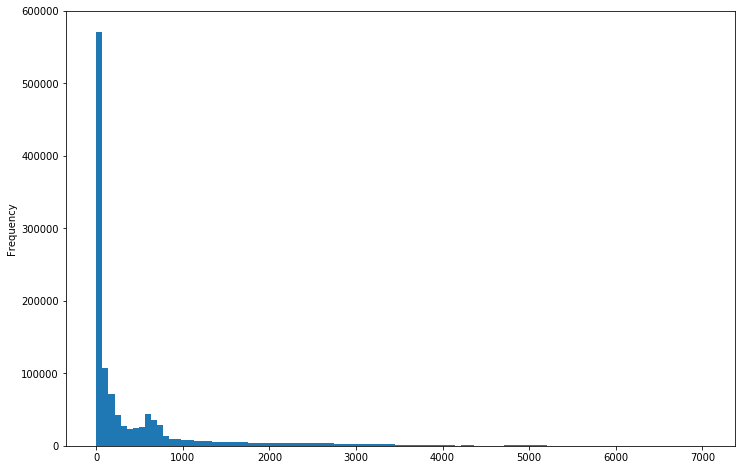

In [40]:
events[(events['event_type'] == 'DELETE') & (events['trade_event'] == False)]['position'].plot(kind='hist', bins=100, figsize=(12, 8))

## 3. Análise de eventos de oscilação de mid_price

### 3.1. Qual são os eventos que ocorrem no book quando há uma abertura de spread?

In [6]:
full_data['wdo_spread'] = full_data['wdo_ask_0'] - full_data['wdo_bid_0']
full_data['dol_spread'] = full_data['dol_ask_0'] - full_data['dol_bid_0']
full_data = full_data[full_data.index > datetime(2019, 2, 13, 11, 5, 0).replace(tzinfo=pytz.utc)]

Considerações sobre cada evento:


- **DELETE**: Eventos que causam abertura por cancelamento de ordem ou trade de uma quantidade.
- **DELETE_FROM**: Trades perfurantes.
- **INSERT**: Trades perfurantes com inserções. (PRECEDIDOS DE DELETE_FROM ou DELETE)
- **CHANGE**: Trades perfurantes com alteração de ordem final, sem inserção. (PRECEDIDOS DE DELETE_FROM)

WDO

In [7]:
wdo_open_spread = full_data[(full_data['wdo_spread'] > 0.5) & (full_data['wdo_spread'] == 0.5).shift(1)]

In [8]:
open_events = events[(events['i'].isin(wdo_open_spread['wdo_inc_code'].values)) & (events['symbol'] == symbol1)]
open_events['event_type'].value_counts()

DELETE         21072
DELETE_FROM    10569
CHANGE           503
INSERT             7
Name: event_type, dtype: int64

DOL

In [9]:
dol_open_spread = full_data[(full_data['dol_spread'] > 0.5) & (full_data['dol_spread'] == 0.5).shift(1)]

In [10]:
open_events = events[(events['i'].isin(dol_open_spread['dol_inc_code'].values)) & (events['symbol'] == symbol2)]
open_events['event_type'].value_counts()

DELETE         7463
DELETE_FROM    1599
CHANGE          304
INSERT          131
Name: event_type, dtype: int64

### 3.2. Qual o percentual de trades ocorridos  em cada evento?

In [11]:
open_events[open_events['event_type'] == 'DELETE']['trade_event'].value_counts() / open_events[open_events['event_type'] == 'DELETE']['trade_event'].value_counts().sum() * 100

True     53.289562
False    46.710438
Name: trade_event, dtype: float64

In [12]:
open_events[open_events['event_type'] == 'DELETE_FROM']['trade_event'].value_counts() / open_events[open_events['event_type'] == 'DELETE_FROM']['trade_event'].value_counts().sum() * 100

True     99.061914
False     0.938086
Name: trade_event, dtype: float64

In [13]:
open_events[open_events['event_type'] == 'INSERT']['trade_event'].value_counts() / open_events[open_events['event_type'] == 'INSERT']['trade_event'].value_counts().sum() * 100

False    74.80916
True     25.19084
Name: trade_event, dtype: float64

In [14]:
open_events[open_events['event_type'] == 'CHANGE']['trade_event'].value_counts() / open_events[open_events['event_type'] == 'CHANGE']['trade_event'].value_counts().sum() * 100

True     97.368421
False     2.631579
Name: trade_event, dtype: float64

### 3.3. Como se comporta a curva de distribuição de retornos dos ativos quando a outra ponta se move?

In [15]:
full_data['dol_mid'] = (full_data['dol_ask_0'] + full_data['dol_bid_0']) / 2
full_data['wdo_mid'] = (full_data['wdo_bid_0'] + full_data['wdo_ask_0']) / 2

In [16]:
# Qual o percentual de ticks em que ambos não coincidem?
(full_data['dol_mid'] == full_data['wdo_mid']).value_counts() / (full_data['dol_mid'] == full_data['wdo_mid']).value_counts().sum() * 100

True     62.86582
False    37.13418
dtype: float64

In [56]:
full_data['state'] = np.nan
full_data.loc[(full_data['wdo_mid'] > full_data['dol_mid']) & ((full_data['wdo_spread'] > 0.5) | (full_data['dol_spread'] > 0.5)), 'state'] = 1
full_data.loc[(full_data['wdo_mid'] < full_data['dol_mid']) & ((full_data['wdo_spread'] > 0.5) | (full_data['dol_spread'] > 0.5)), 'state'] = -1
full_data.loc[(full_data['wdo_mid'] == full_data['dol_mid']) & (full_data['wdo_spread'] == 0.5) & (full_data['dol_spread'] == 0.5), 'state'] = 0
full_data['state'] = full_data['state'].ffill().fillna(value=0)

full_data = full_data[(full_data.index >= events[events['status'] == 'OPEN'].index[0]) & (full_data.index <= events[events['status'] == 'CLOSED'].index[-1])]

In [58]:
NEUTRAL = 0
WDO_UP = 1
WDO_DOWN = -1
DOL_UP = 2
DOL_DOWN = -2

full_data['wdo_fut_return'] = full_data['wdo_mid'].shift(-1) - full_data['wdo_mid']
full_data['dol_fut_return'] = full_data['dol_mid'].shift(-1) - full_data['dol_mid']
full_data['wdo_past_return'] = full_data['wdo_mid']- full_data['wdo_mid'].shift(1)
full_data['dol_past_return'] = full_data['dol_mid']- full_data['dol_mid'].shift(1)

full_data['mover'] = np.nan
full_data.loc[(full_data['state'] > NEUTRAL) & (full_data['state'].shift(1) == NEUTRAL) & (full_data['wdo_mid'] != full_data['wdo_mid'].shift(1)), 'base_mover'] = WDO_UP
full_data.loc[(full_data['state'] < NEUTRAL) & (full_data['state'].shift(1) == NEUTRAL) & (full_data['wdo_mid'] != full_data['wdo_mid'].shift(1)), 'base_mover'] = WDO_DOWN
full_data.loc[(full_data['state'] < NEUTRAL) & (full_data['state'].shift(1) == NEUTRAL) & (full_data['dol_mid'] != full_data['dol_mid'].shift(1)), 'base_mover'] = DOL_UP
full_data.loc[(full_data['state'] > NEUTRAL) & (full_data['state'].shift(1) == NEUTRAL) & (full_data['dol_mid'] != full_data['dol_mid'].shift(1)), 'base_mover'] = DOL_DOWN

full_data['event_mover'] = np.nan
full_data['event_mover'][abs(full_data['base_mover']) == 2] = full_data['dol_event'][abs(full_data['base_mover']) == 2]
full_data['event_mover'][abs(full_data['base_mover']) == 1] = full_data['wdo_event'][abs(full_data['base_mover']) == 1]

full_data['event_mover'] = full_data['event_mover'].ffill()
full_data['event_mover'][full_data['state'] == 0] = np.nan

mover = full_data['base_mover'].copy()
full_data['mover'] = full_data['base_mover'].ffill() * abs(full_data['state'])

In [59]:
ret_distribution = full_data[full_data['mover'] == 1]['wdo_fut_return'].value_counts()
ret_distribution= ret_distribution[ret_distribution.index != 0]

In [60]:
def plot_distribution(ax, data, tag='+'):
    data = data.index * data
    ax.bar([tag], [data[data.index > 0].sum()], color='limegreen')
    ax.bar([tag], [data[data.index < 0].sum()], color='red')
    
def plot_net_account(ax, data, tag):
    plot_value = (data.index * data).sum()
    if plot_value > 0:
        ax.bar([tag], [plot_value], color='limegreen')
    else:
        ax.bar([tag], [plot_value], color='red')

#### 3.3.1. Distribution

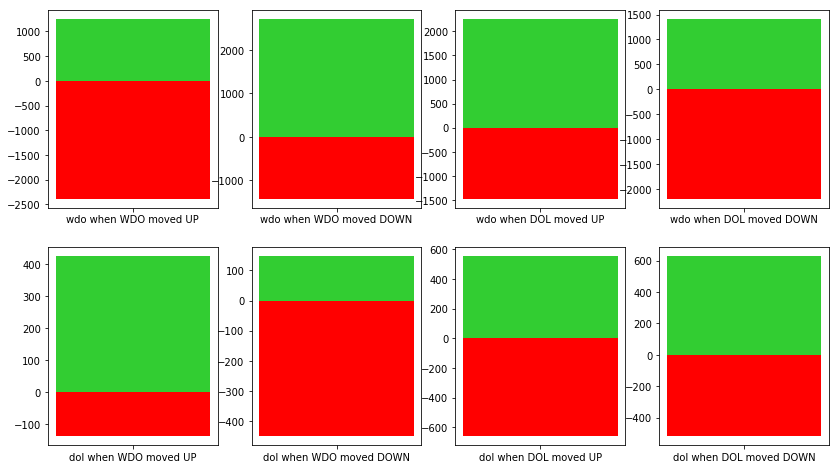

In [61]:
fig, ax = plt.subplots(2, 4, figsize=[14, 8])
tags = ['WDO moved UP', 'WDO moved DOWN', 'DOL moved UP', 'DOL moved DOWN']
for i, observe in enumerate(['wdo', 'dol']):
    for j, movement in enumerate([WDO_UP, WDO_DOWN, DOL_UP, DOL_DOWN]):
        variation_distribution = full_data.loc[full_data['mover'] == movement, observe + '_fut_return'].value_counts()
        variation_distribution = variation_distribution[variation_distribution.index != 0]
        tag = observe + ' when ' + tags[j]
        plot_distribution(ax[i][j], variation_distribution, tag=tag)

#### 3.3.2. Net moves

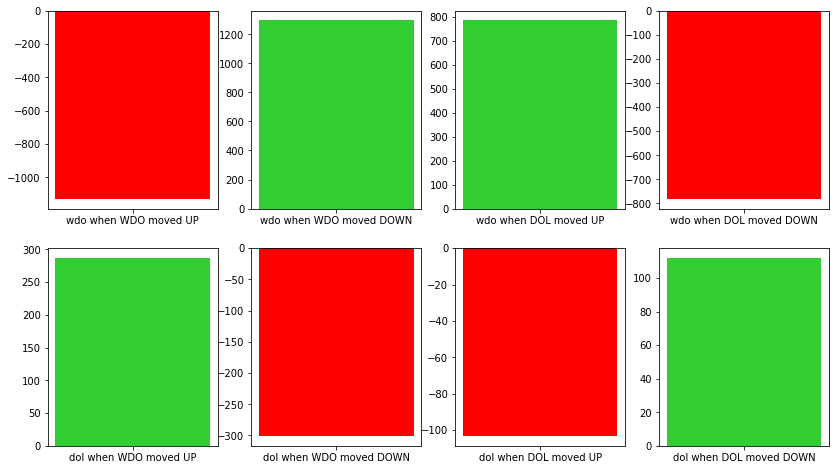

In [62]:
fig, ax = plt.subplots(2, 4, figsize=[14, 8])
tags = ['WDO moved UP', 'WDO moved DOWN', 'DOL moved UP', 'DOL moved DOWN']
for i, observe in enumerate(['wdo', 'dol']):
    for j, movement in enumerate([WDO_UP, WDO_DOWN, DOL_UP, DOL_DOWN]):
        variation_distribution = full_data.loc[full_data['mover'] == movement, observe + '_fut_return'].value_counts()
        variation_distribution = variation_distribution[variation_distribution.index != 0]
        tag = observe + ' when ' + tags[j]
        plot_net_account(ax[i][j], variation_distribution, tag=tag)

#### 3.3.3. Relação de vezes entre a contagem de eventos

In [63]:
tags = ['WDO moved UP', 'WDO moved DOWN', 'DOL moved UP', 'DOL moved DOWN']
for j, movement in enumerate([WDO_UP, WDO_DOWN, DOL_UP, DOL_DOWN]):
    variation_distribution = full_data.loc[full_data['mover'] == movement, 'wdo' + '_fut_return'].value_counts()
    variation_distribution = variation_distribution[variation_distribution.index != 0]
    data = (variation_distribution.index * variation_distribution).sum()

    variation_distribution2 = full_data.loc[full_data['mover'] == movement, 'dol' + '_fut_return'].value_counts()
    variation_distribution2 = variation_distribution2[variation_distribution2.index != 0]
    data2 = (variation_distribution2.index * variation_distribution2).sum()
    
    print(j, '- {:.2f}'.format(abs(data / data2)))

0 - 3.94
1 - 4.30
2 - 7.59
3 - 6.97


In [64]:
wdo_level_data['ask_var'] = abs(wdo_level_data['wdo_ask_0'] - wdo_level_data['wdo_ask_0'].shift(1))
wdo_level_data['bid_var'] = abs(wdo_level_data['wdo_bid_0'] - wdo_level_data['wdo_bid_0'].shift(1))

In [67]:
dol_level_data['ask_var'] = abs(dol_level_data['dol_ask_0'] - dol_level_data['dol_ask_0'].shift(1))
dol_level_data['bid_var'] = abs(dol_level_data['dol_bid_0'] - dol_level_data['dol_bid_0'].shift(1))

In [68]:
dol_level_data[dol_level_data['dol_event'] == 'DELETE_FROM']['bid_var'].value_counts()

0.0     2624
0.5      820
1.0       22
1.5        8
14.0       2
2.0        2
9.0        1
8.0        1
Name: bid_var, dtype: int64

In [69]:
dol_level_data[dol_level_data['dol_event'] == 'DELETE_FROM']['ask_var'].value_counts()

0.0    2647
0.5     808
1.0      20
1.5       4
2.0       1
Name: ask_var, dtype: int64

In [70]:
wdo_mover_data = full_data[abs(full_data['base_mover']) == 1]
print(wdo_mover_data['event_mover'].value_counts())
print(wdo_mover_data['event_mover'].value_counts().sum())

DELETE         6625
DELETE_FROM    4792
CHANGE          228
INSERT            5
Name: event_mover, dtype: int64
11650


In [71]:
dol_mover_data = full_data[abs(full_data['base_mover']) == 2]
print(dol_mover_data['event_mover'].value_counts())
print(dol_mover_data['event_mover'].value_counts().sum())

DELETE         5192
DELETE_FROM    1268
CHANGE          264
INSERT          102
Name: event_mover, dtype: int64
6826


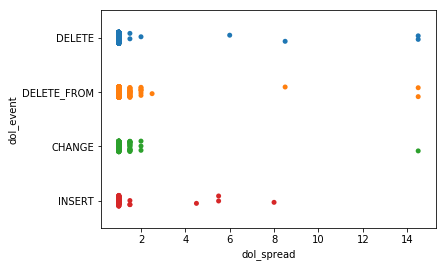

In [87]:
sns.stripplot(x='dol_spread', y='dol_event', data=dol_mover_data)

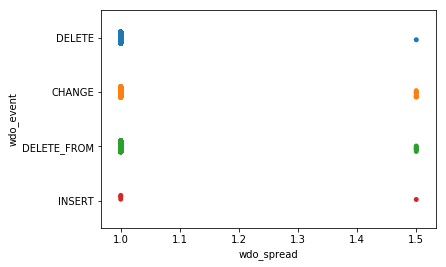

In [73]:
sns.stripplot(x='wdo_spread', y='wdo_event', data=wdo_mover_data)

### 3.4. As análise de distribuição de retornos se alteram quando a outra ponta se move por diferentes tipos de eventos?

#### 3.4.1. DELETE

0 - 4.93
1 - 6.06
2 - 3.07
3 - 3.41


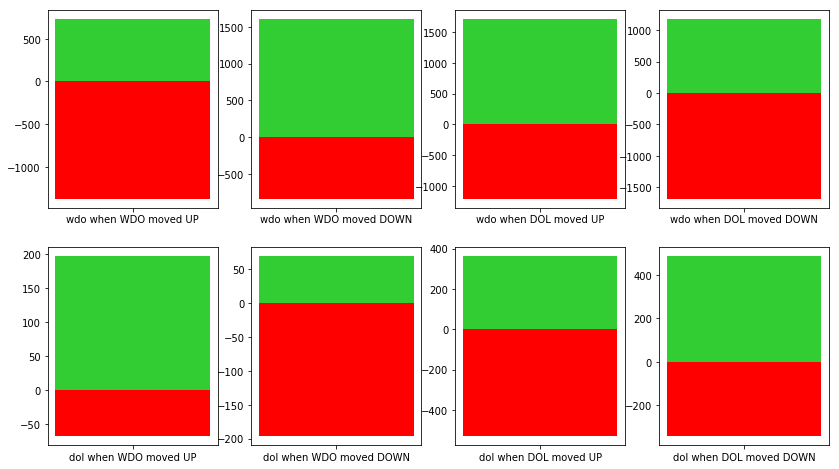

In [74]:
event_slice = 'DELETE'

fig, ax = plt.subplots(2, 4, figsize=[14, 8])
tags = ['WDO moved UP', 'WDO moved DOWN', 'DOL moved UP', 'DOL moved DOWN']
for i, observe in enumerate(['wdo', 'dol']):
    for j, movement in enumerate([WDO_UP, WDO_DOWN, DOL_UP, DOL_DOWN]):
        variation_distribution = full_data.loc[full_data['mover'] == movement]
        variation_distribution = variation_distribution.loc[variation_distribution['event_mover'] == event_slice, observe + '_fut_return'].value_counts()
        variation_distribution = variation_distribution[variation_distribution.index != 0]
        tag = observe + ' when ' + tags[j]
        plot_distribution(ax[i][j], variation_distribution, tag=tag)
        
# Relação entre plots
for j, movement in enumerate([WDO_UP, WDO_DOWN, DOL_UP, DOL_DOWN]):
    mover_slice = full_data.loc[full_data['mover'] == movement]
    variation_distribution = mover_slice.loc[mover_slice['event_mover'] == event_slice, 'wdo_fut_return'].value_counts()
    variation_distribution = variation_distribution[variation_distribution.index != 0]
    data = (variation_distribution.index * variation_distribution).sum()
    
    variation_distribution2 = mover_slice.loc[mover_slice['event_mover'] == event_slice, 'dol_fut_return'].value_counts()
    variation_distribution2 = variation_distribution2[variation_distribution2.index != 0]
    data2 = (variation_distribution2.index * variation_distribution2).sum()
    
    print(j, '- {:.2f}'.format(abs(data / data2)))

#### 3.4.2. DELETE_FROM

0 - 3.09
1 - 2.88
2 - 4.60
3 - 5.90


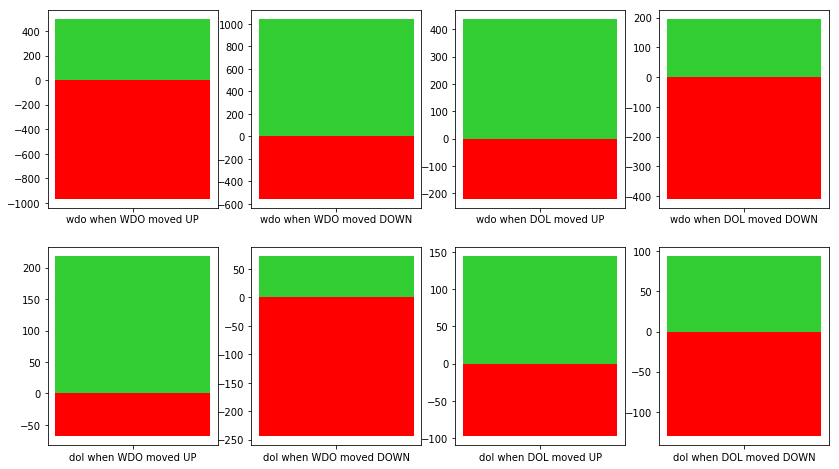

In [75]:
event_slice = 'DELETE_FROM'

fig, ax = plt.subplots(2, 4, figsize=[14, 8])
tags = ['WDO moved UP', 'WDO moved DOWN', 'DOL moved UP', 'DOL moved DOWN']
for i, observe in enumerate(['wdo', 'dol']):
    for j, movement in enumerate([WDO_UP, WDO_DOWN, DOL_UP, DOL_DOWN]):
        variation_distribution = full_data.loc[full_data['mover'] == movement]
        variation_distribution = variation_distribution.loc[variation_distribution['event_mover'] == event_slice, observe + '_fut_return'].value_counts()
        variation_distribution = variation_distribution[variation_distribution.index != 0]
        tag = observe + ' when ' + tags[j]
        plot_distribution(ax[i][j], variation_distribution, tag=tag)
        
# Relação entre plots
for j, movement in enumerate([WDO_UP, WDO_DOWN, DOL_UP, DOL_DOWN]):
    mover_slice = full_data.loc[full_data['mover'] == movement]
    variation_distribution = mover_slice.loc[mover_slice['event_mover'] == event_slice, 'wdo_fut_return'].value_counts()
    variation_distribution = variation_distribution[variation_distribution.index != 0]
    data = (variation_distribution.index * variation_distribution).sum()
    
    variation_distribution2 = mover_slice.loc[mover_slice['event_mover'] == event_slice, 'dol_fut_return'].value_counts()
    variation_distribution2 = variation_distribution2[variation_distribution2.index != 0]
    data2 = (variation_distribution2.index * variation_distribution2).sum()
    
    print(j, '- {:.2f}'.format(abs(data / data2)))

#### 3.4.2. INSERT

0 - 3.00
1 - inf
2 - inf
3 - 0.64


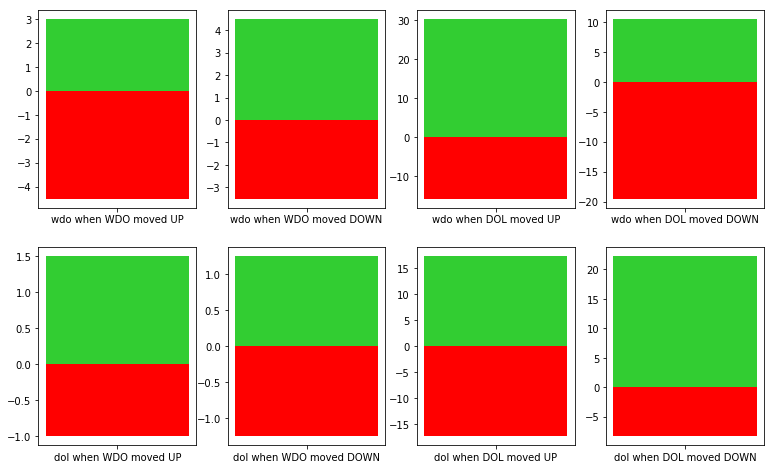

In [76]:
event_slice = 'INSERT'

fig, ax = plt.subplots(2, 4, figsize=[13, 8])
tags = ['WDO moved UP', 'WDO moved DOWN', 'DOL moved UP', 'DOL moved DOWN']
for i, observe in enumerate(['wdo', 'dol']):
    for j, movement in enumerate([WDO_UP, WDO_DOWN, DOL_UP, DOL_DOWN]):
        variation_distribution = full_data.loc[full_data['mover'] == movement]
        variation_distribution = variation_distribution.loc[variation_distribution['event_mover'] == event_slice, observe + '_fut_return'].value_counts()
        variation_distribution = variation_distribution[variation_distribution.index != 0]
        tag = observe + ' when ' + tags[j]
        plot_distribution(ax[i][j], variation_distribution, tag=tag)

# Relação entre plots
for j, movement in enumerate([WDO_UP, WDO_DOWN, DOL_UP, DOL_DOWN]):
    mover_slice = full_data.loc[full_data['mover'] == movement]
    variation_distribution = mover_slice.loc[mover_slice['event_mover'] == event_slice, 'wdo_fut_return'].value_counts()
    variation_distribution = variation_distribution[variation_distribution.index != 0]
    data = (variation_distribution.index * variation_distribution).sum()
    
    variation_distribution2 = mover_slice.loc[mover_slice['event_mover'] == event_slice, 'dol_fut_return'].value_counts()
    variation_distribution2 = variation_distribution2[variation_distribution2.index != 0]
    data2 = (variation_distribution2.index * variation_distribution2).sum()
    
    print(j, '- {:.2f}'.format(abs(data / data2)))

#### 3.4.2. CHANGE

0 - 3.85
1 - 8.44
2 - 3.19
3 - 4.98


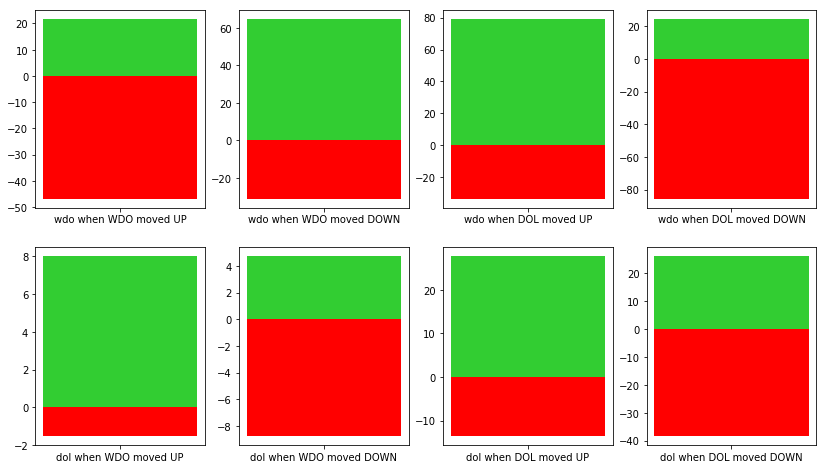

In [77]:
event_slice = 'CHANGE'

fig, ax = plt.subplots(2, 4, figsize=[14, 8])
tags = ['WDO moved UP', 'WDO moved DOWN', 'DOL moved UP', 'DOL moved DOWN']
for i, observe in enumerate(['wdo', 'dol']):
    for j, movement in enumerate([WDO_UP, WDO_DOWN, DOL_UP, DOL_DOWN]):
        variation_distribution = full_data.loc[full_data['mover'] == movement]
        variation_distribution = variation_distribution.loc[variation_distribution['event_mover'] == event_slice, observe + '_fut_return'].value_counts()
        variation_distribution = variation_distribution[variation_distribution.index != 0]
        tag = observe + ' when ' + tags[j]
        plot_distribution(ax[i][j], variation_distribution, tag=tag)
        
# Relação entre plots
for j, movement in enumerate([WDO_UP, WDO_DOWN, DOL_UP, DOL_DOWN]):
    mover_slice = full_data.loc[full_data['mover'] == movement]
    variation_distribution = mover_slice.loc[mover_slice['event_mover'] == event_slice, 'wdo_fut_return'].value_counts()
    variation_distribution = variation_distribution[variation_distribution.index != 0]
    data = (variation_distribution.index * variation_distribution).sum()
    
    variation_distribution2 = mover_slice.loc[mover_slice['event_mover'] == event_slice, 'dol_fut_return'].value_counts()
    variation_distribution2 = variation_distribution2[variation_distribution2.index != 0]
    data2 = (variation_distribution2.index * variation_distribution2).sum()
    
    print(j, '- {:.2f}'.format(abs(data / data2)))